In [7]:
# Install necessary libraries in Google Colab
!pip install category_encoders imbalanced-learn deap

In [8]:
# %% Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import BinaryEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, precision_recall_curve, accuracy_score,
)
from imblearn.over_sampling import SMOTE
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.impute import SimpleImputer

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# %% Step 1: Load the Datasets
# File paths
application_data_path = "/content/drive/MyDrive/Colab Notebooks/AI-Project/application_record.csv"
credit_data_path = "/content/drive/MyDrive/Colab Notebooks/AI-Project/credit_record.csv"

# Load datasets
application_data = pd.read_csv(application_data_path)
credit_data = pd.read_csv(credit_data_path)

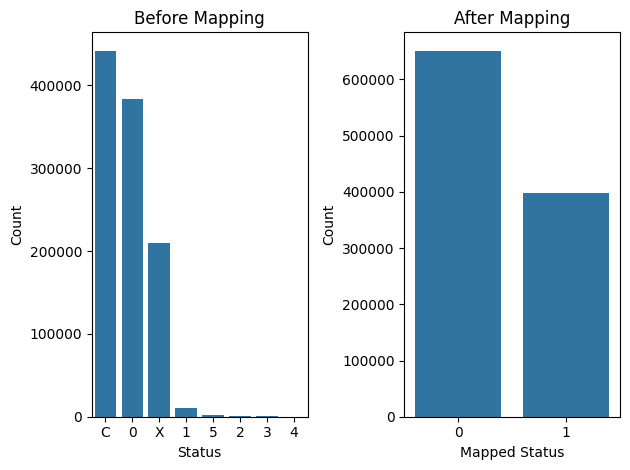

In [11]:
# %% Step 2: Exploratory Data Analysis (EDA)
# Visualize initial status distribution in credit data
plt.subplot(1, 2, 1)
sns.countplot(x=credit_data["STATUS"], order=credit_data["STATUS"].value_counts().index)
plt.title("Before Mapping")
plt.xlabel("Status")
plt.ylabel("Count")

# Handle mapping of statuses
status_mapping = {"C": 0, "X": 0, "0": 1, "1": 1, "2": 1, "3": 1, "4": 1, "5": 1}
credit_data["STATUS"] = credit_data["STATUS"].map(status_mapping)

# Visualize status distribution after mapping
plt.subplot(1, 2, 2)
sns.countplot(x=credit_data["STATUS"], order=credit_data["STATUS"].value_counts().index)
plt.title("After Mapping")
plt.xlabel("Mapped Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [12]:
# %% Step 3: Handle Missing Values and Duplicates
# Handle missing values with Simple Imputer
imputer = SimpleImputer(strategy="most_frequent")  # Create an imputer instance
application_data = pd.DataFrame(
    imputer.fit_transform(application_data), columns=application_data.columns
)
credit_data = pd.DataFrame(
    imputer.fit_transform(credit_data), columns=credit_data.columns
)

print("Missing Values in Application Data:\n", application_data.isnull().sum())
print("Missing Values in Credit Data:\n", credit_data.isnull().sum())

# Count unique values
print("Unique Values in Application Data:\n", application_data.nunique())
print("Unique Values in Credit Data:\n", credit_data.nunique())

# Handle Duplicates
print("Duplicate Rows in Application Data:", application_data.duplicated().sum())
print("Duplicate Rows in Credit Data:", credit_data.duplicated().sum())

# Replace missing values
application_data["OCCUPATION_TYPE"] = application_data["OCCUPATION_TYPE"].fillna("Unknown")

Missing Values in Application Data:
 ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
dtype: int64
Missing Values in Credit Data:
 ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64
Unique Values in Application Data:
 ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406

In [13]:
# %% Step 4: Preprocessing
# Drop unnecessary columns
application_data.drop(columns=["FLAG_MOBIL"], inplace=True)

# Rename columns for clarity
application_data.rename(
    columns={"AMT_INCOME_TOTAL": "TOTAL_INCOME", "DAYS_BIRTH": "AGE"}, inplace=True
)
application_data["AGE"] = -application_data["AGE"] // 365
application_data["DAYS_EMPLOYED"] = -application_data["DAYS_EMPLOYED"] // 365
application_data["DAYS_EMPLOYED"] = application_data["DAYS_EMPLOYED"].replace(365243, 0)
application_data["TOTAL_INCOME"] = application_data["TOTAL_INCOME"] / 100

# One-Hot Encoding for categorical variables
categorical_columns = [
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "FLAG_EMAIL",
    "FLAG_PHONE",
    "FLAG_WORK_PHONE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
]
one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_data = one_hot_encoder.fit_transform(application_data[categorical_columns])
encoded_columns = one_hot_encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(
    encoded_data, columns=encoded_columns, index=application_data.index
)
application_data = pd.concat(
    [application_data.drop(columns=categorical_columns), encoded_df], axis=1
)

# Binary Encoding for specific columns
columns_to_encode = ["CNT_CHILDREN", "OCCUPATION_TYPE", "CNT_FAM_MEMBERS"]
binary_encoder = BinaryEncoder(cols=columns_to_encode, drop_invariant=True)
application_data = binary_encoder.fit_transform(application_data)

# Scale numeric features
numeric_columns = ["DAYS_EMPLOYED", "AGE", "TOTAL_INCOME"]
scaler = StandardScaler()
application_data[numeric_columns] = scaler.fit_transform(application_data[numeric_columns])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 40 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 36457 non-null  object 
 1   CNT_CHILDREN_1                                     36457 non-null  int64  
 2   CNT_CHILDREN_2                                     36457 non-null  int64  
 3   CNT_CHILDREN_3                                     36457 non-null  int64  
 4   TOTAL_INCOME                                       36457 non-null  float64
 5   AGE                                                36457 non-null  float64
 6   DAYS_EMPLOYED                                      36457 non-null  float64
 7   OCCUPATION_TYPE_0                                  36457 non-null  int64  
 8   OCCUPATION_TYPE_1                                  36457 non-null  int64  
 9   OCCUPA

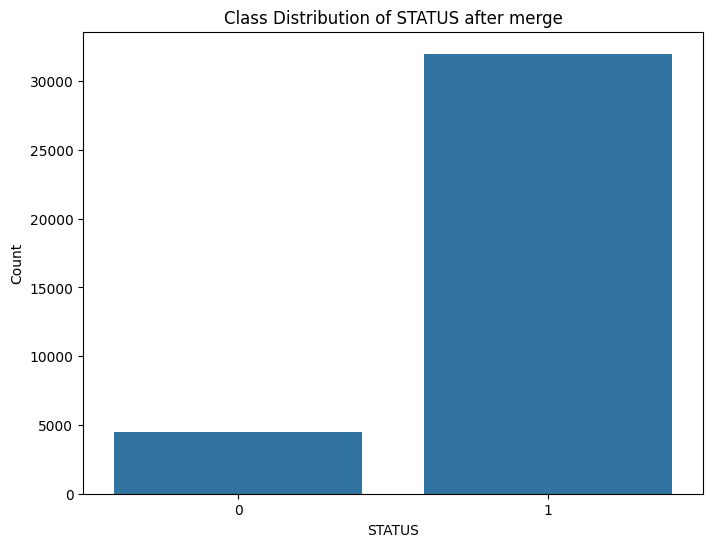

In [14]:
# %% Step 5: Merging Datasets
# Group credit data by ID and summarize the status
grouped_credit_data = credit_data.groupby("ID")["STATUS"].max().reset_index()
merged_data = pd.merge(application_data, grouped_credit_data, on="ID", how="inner")

# Display merged data info
print("Merged Data Info:\n", merged_data.info())

# Visualize class distribution in merged data
plt.figure(figsize=(8, 6))
sns.countplot(x="STATUS", data=merged_data)
plt.title("Class Distribution of STATUS after merge")
plt.xlabel("STATUS")
plt.ylabel("Count")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


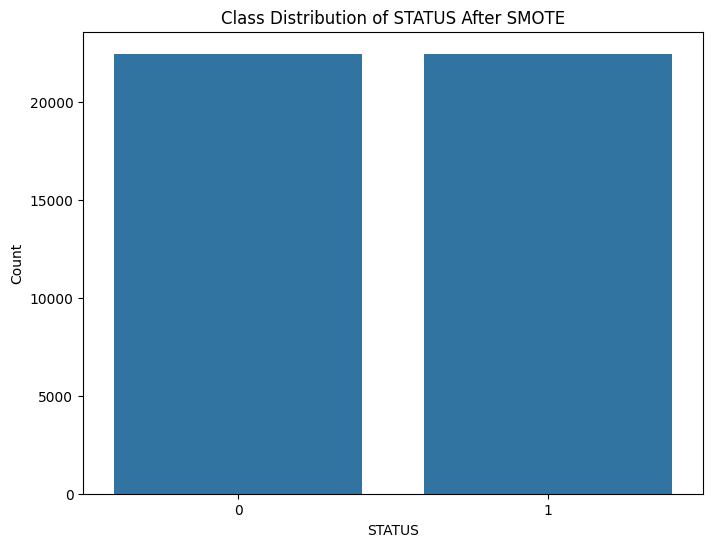

In [15]:
# %% Step 6: Oversampling with SMOTE
X = merged_data.drop(columns=["STATUS"])
y = merged_data["STATUS"]
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Visualize class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution of STATUS After SMOTE")
plt.xlabel("STATUS")
plt.ylabel("Count")
plt.show()

# Reapply scaling to the resampled data
X_train_resampled[numeric_columns] = scaler.fit_transform(
    X_train_resampled[numeric_columns]
)
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [16]:
# %% Step 7: Feature Selection with Genetic Algorithms
def evaluate(individual):
    selected_features = [
        feature for feature, include in zip(X.columns, individual) if include
    ]
    if len(selected_features) == 0:
        return (0,)

    # Train and evaluate a Decision Tree on the selected subset
    model = DecisionTreeClassifier()
    model.fit(X_train[selected_features], y_train)
    y_pred = model.predict(X_val[selected_features])
    return (accuracy_score(y_val, y_pred),)


# Genetic Algorithm Setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_bool,
    n=len(X.columns),
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=50)
result = algorithms.eaSimple(
    population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False
)

Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}
Best Parameters for MLP: {'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 300}
Decision Tree Accuracy: 0.8429328944962516
KNN Accuracy: 0.7350521119034559
MLP Accuracy: 0.8720058511610898


<ipython-input-17-fbc5fc485b18>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


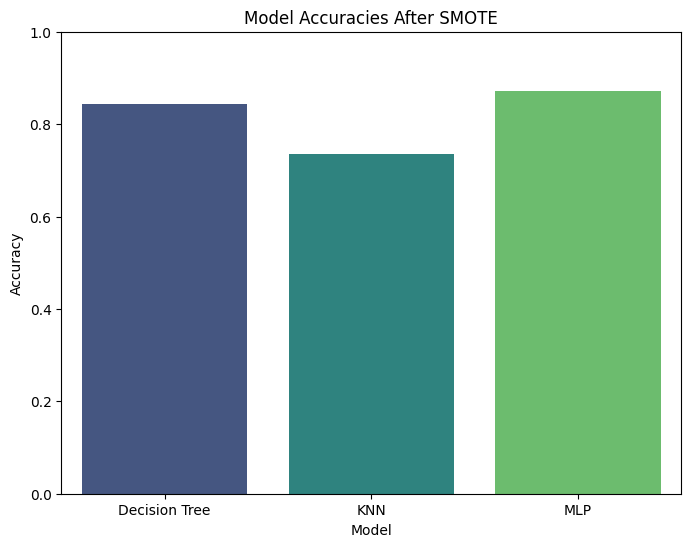

In [17]:
# %% Step 8: Model Training and Hyperparameter Tuning
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train_resampled, y_train_resampled)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_resampled, y_train_resampled)

# Multi-Layer Perceptron
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu",
    solver="adam",
    max_iter=500,
    learning_rate_init=0.001,
    random_state=42,
    early_stopping=True,
)
mlp.fit(X_train_resampled, y_train_resampled)

# Hyperparameter Tuning for Decision Tree
param_grid_dt = {
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10],
}
grid_dt = GridSearchCV(
    DecisionTreeClassifier(), param_grid_dt, cv=3, scoring="accuracy"
)
grid_dt.fit(X_train_resampled, y_train_resampled)
print("Best Parameters for Decision Tree:", grid_dt.best_params_)

# Hyperparameter Tuning for MLP
param_grid_mlp = {
    "hidden_layer_sizes": [(64, 32, 16), (128, 64)],
    "learning_rate_init": [0.001, 0.0001],
    "max_iter": [300, 500],
}
grid_mlp = GridSearchCV(
    MLPClassifier(random_state=42, early_stopping=True),
    param_grid_mlp,
    scoring="accuracy",
    cv=3,
)
grid_mlp.fit(X_train_resampled, y_train_resampled)
print("Best Parameters for MLP:", grid_mlp.best_params_)
y_pred_dt = dt.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_mlp = mlp.predict(X_test)

# Accuracy
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))

# Model Comparison Visualization
model_accuracies = {
    "Decision Tree": accuracy_score(y_test, y_pred_dt),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "MLP": accuracy_score(y_test, y_pred_mlp),
}

plt.figure(figsize=(8, 6))
sns.barplot(
    x=list(model_accuracies.keys()),
    y=list(model_accuracies.values()),
    palette="viridis",
)
plt.title("Model Accuracies After SMOTE")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

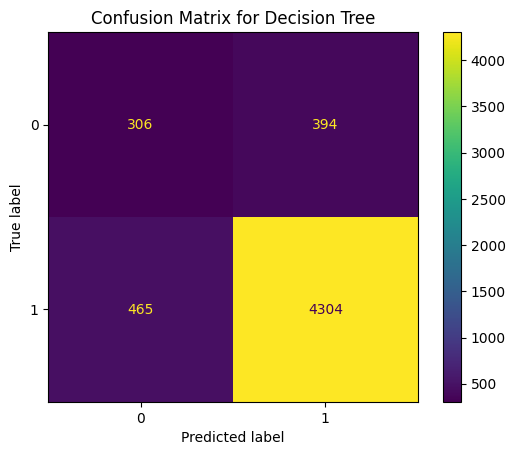

In [18]:
# %% Confusion Matrix for Decision Tree
conf_matrix = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dt.classes_)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix for Decision Tree")
plt.show()

In [19]:
# %% Classification Report and Additional Metrics
print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))

# ROC-AUC Scores
roc_auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
roc_auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
roc_auc_mlp = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])

print(f"\nROC-AUC Score for Decision Tree: {roc_auc_dt:.4f}")
print(f"ROC-AUC Score for KNN: {roc_auc_knn:.4f}")
print(f"ROC-AUC Score for MLP: {roc_auc_mlp:.4f}")


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42       700
           1       0.92      0.90      0.91      4769

    accuracy                           0.84      5469
   macro avg       0.66      0.67      0.66      5469
weighted avg       0.85      0.84      0.85      5469


ROC-AUC Score for Decision Tree: 0.6700
ROC-AUC Score for KNN: 0.7122
ROC-AUC Score for MLP: 0.5000


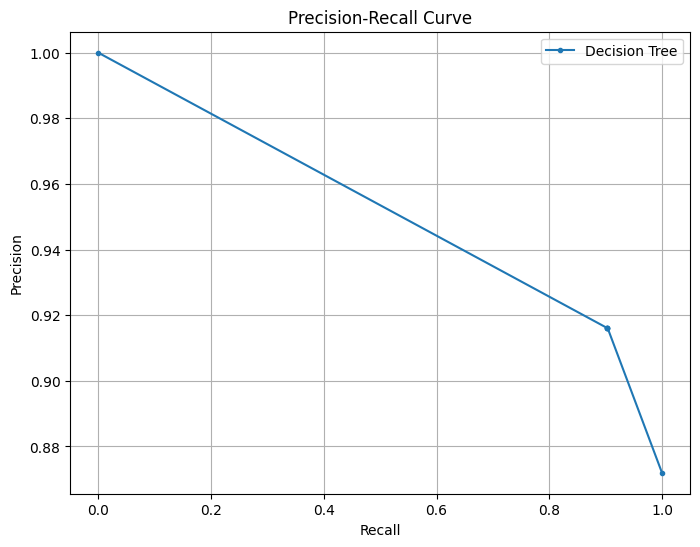

In [20]:
# %% Precision-Recall Curve for the Best Model (Decision Tree Example)
precision, recall, thresholds = precision_recall_curve(
    y_test, dt.predict_proba(X_test)[:, 1]
)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label="Decision Tree")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


Model Accuracy Summary:
Decision Tree Accuracy: 0.8429
KNN Accuracy: 0.7351
MLP Accuracy: 0.8720

Accuracy Summary DataFrame:
           Model  Accuracy
0  Decision Tree  0.842933
1            KNN  0.735052
2            MLP  0.872006


<ipython-input-21-665ced0269be>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


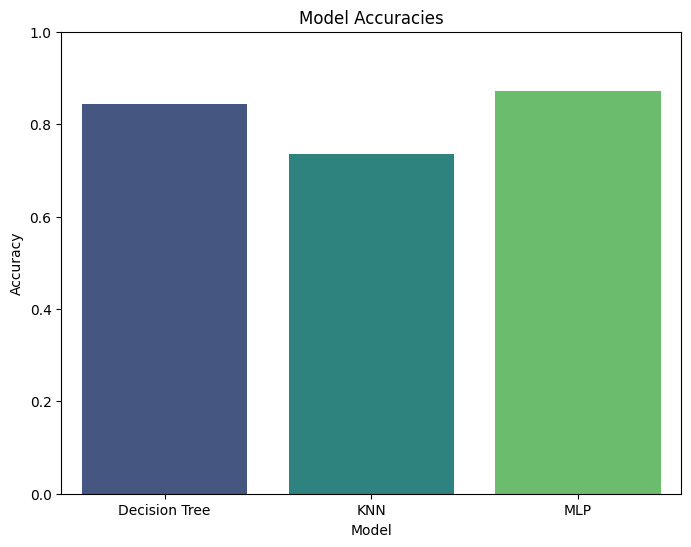

In [21]:
# %% Model Accuracy Summary
print("\nModel Accuracy Summary:")
print("===================================")
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"MLP Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")

# Optionally, store accuracies in a DataFrame for better visualization
accuracy_summary = pd.DataFrame({
    'Model': ['Decision Tree', 'KNN', 'MLP'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_mlp)
    ]
})

# Print the summary DataFrame
print("\nAccuracy Summary DataFrame:")
print(accuracy_summary)

# You can also visualize the accuracy summary if desired
plt.figure(figsize=(8, 6))
sns.barplot(
    x='Model',
    y='Accuracy',
    data=accuracy_summary,
    palette='viridis'
)
plt.title("Model Accuracies")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

In [22]:
# %% Save Models
from joblib import dump

# Save the models
dump(knn, 'knn_model.joblib')
dump(dt, 'decision_tree_model.joblib')
dump(mlp, 'mlp_model.joblib')

print("Models saved successfully!")

Models saved successfully!
